In [79]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from scipy.optimize import minimize, least_squares
from typing import Tuple
import itertools as it
from skimage.util import img_as_ubyte
import skimage
import torch
import torch.nn.functional as func

In [80]:
# name = "T_S04856"
name = "T_S04910"
# name = "T_S04911"
# name = "T_S04912"
# name = "T_S04923"

png_file = Path(f"../../data/seathru/D3/D3/linearPNG/{name}.png")
tif_file = Path(f"../../data/seathru/D3/D3/depth/depth{name}.tif")

In [81]:
clusters = 10

In [82]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [83]:
def uint8_2_double(array: np.ndarray):
    return array.astype(np.float64) / 255.0

def double_2_uint8(array: np.ndarray):
    return (array * 255).astype(np.uint8)

In [84]:
def imshow(img: np.ndarray, color_channel="rgb"):


    if img.dtype == np.float64 and len(img.shape) == 3:
        img = double_2_uint8(img)

    if color_channel == "bgr":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_channel == "hsv":
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    plt.imshow(img)

    if len(img.shape) == 2:
        plt.colorbar()

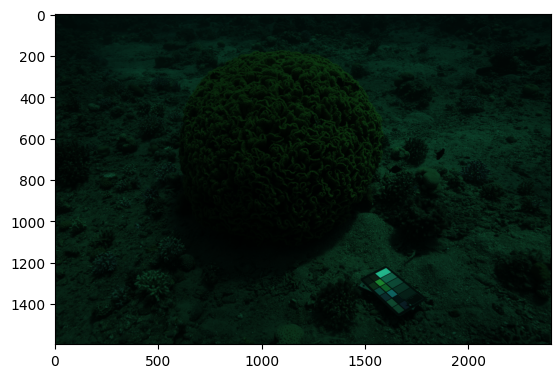

In [85]:
png = uint8_2_double(cv2.imread(png_file))
height, width, _ = png.shape

imshow(png, color_channel="bgr")

In [86]:
png.dtype

dtype('float64')

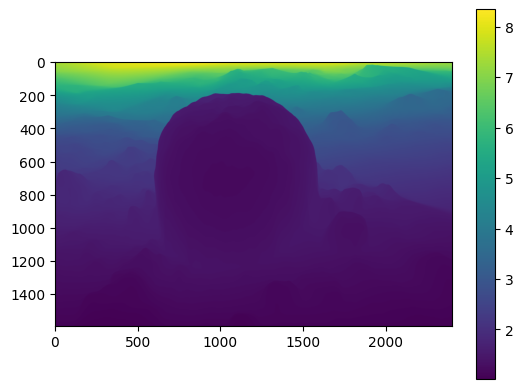

In [87]:
tif_image = Image.open(tif_file)
tif = np.array(tif_image)
tif = cv2.resize(tif, (width, height),  interpolation = cv2.INTER_NEAREST)

imshow(tif)

In [88]:
png.shape, tif.shape

((1596, 2400, 3), (1596, 2400))

In [89]:
tif.min(), tif.max()

(np.float32(1.017077), np.float32(8.343443))

In [90]:
tif_flat = tif.flatten()

tif_flat.shape

(3830400,)

## Backscatter Estimation

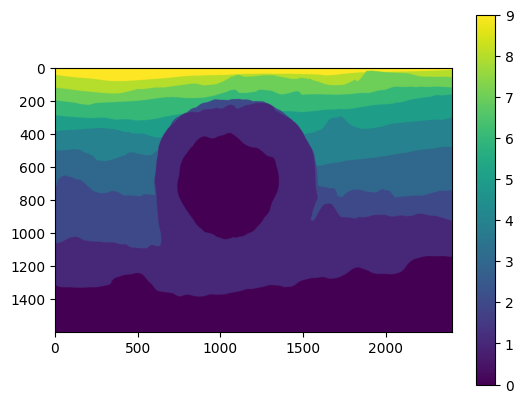

In [ ]:
# kmeans = KMeans(n_clusters=clusters, random_state=0, n_init="auto").fit(tif_flat[tif_flat != 0].reshape(-1, 1))
# labels = np.zeros(tif_flat.shape, dtype=np.uint8)
# labels[tif_flat != 0] = kmeans.labels_
# labels[tif_flat == 0] = 255 # Use 255 to represent nan
# means = np.array(kmeans.cluster_centers_).flatten()
# means_args = np.argsort(means)

# labels_new = np.zeros_like(labels)
# labels_new[labels == 255] = clusters + 1

# for current_label in range(clusters):
#     new_label = np.nonzero(means_args == current_label)[0]
#     labels_new[labels == current_label] = new_label

# labels = labels_new.reshape((height, width))
# imshow(labels)

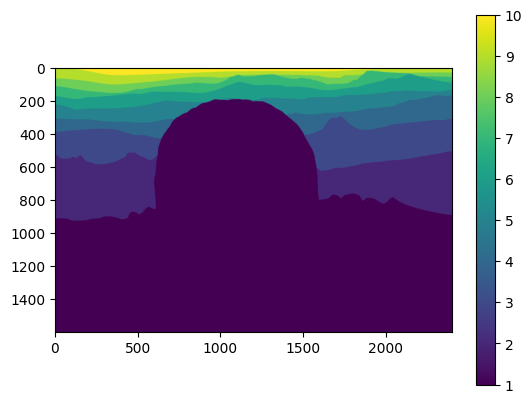

In [160]:
_, edges = np.histogram(tif_flat, clusters)

labels = np.zeros(tif.shape, dtype=np.uint8)
for i in range(clusters + 1):
    labels[np.logical_and(tif <= edges[i], labels == 0)] = i

imshow(labels)

In [155]:
np.unique_counts(labels)

UniqueCountsResult(values=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), counts=array([1037986, 1126716,  340131,  306873,  257138,  171602,  200181,
        186927,  100956,  101890]))

In [161]:
dark_pixels = []
z_values = []

for i in range(1, clusters + 1):
    mask = labels == i
    filtered = png * mask[:, :, np.newaxis]

    b = png[:, :, 0]
    g = png[:, :, 1]
    r = png[:, :, 2]

    b_filtered = b[mask].flatten()
    g_filtered = g[mask].flatten()
    r_filtered = r[mask].flatten()

    pixels = np.array([[b,g,r] for b,g,r in zip(b_filtered, g_filtered , r_filtered)])
    idx = np.nonzero(np.all(pixels <= np.percentile(pixels, 1, axis=0), axis=1))
    selected_pixels = pixels[idx]

    filtered_tif = tif[mask].flatten()
    z = filtered_tif[idx]

    dark_pixels.extend(selected_pixels.tolist())
    z_values.extend(z.tolist())

dark_pixels = np.array(dark_pixels)
z_values = np.array(z_values)

In [162]:
png.shape, 1596 * 2400

((1596, 2400, 3), 3830400)

In [163]:
dark_pixels.shape[0] / (1596 * 2400), z_values.shape

(0.02515455304928989, (96352,))

In [164]:
tif.min(), tif.max()

(np.float32(1.017077), np.float32(8.343443))

In [165]:
z_values

array([1.24803424, 1.24751532, 1.28711152, ..., 7.71093845, 7.68502378,
       7.6849041 ], shape=(96352,))

In [166]:
def estimate_backscatter(B_inf: float, beta_B: float, J_prime: float, beta_D_prime: float, z):
    return B_inf * (1 - np.exp(- beta_B * z)) + (J_prime * np.exp(- beta_D_prime * z))

In [167]:
def optimize_estimate_backscatter(arguments: Tuple[float, float, float, float], B_hat: np.ndarray, z: np.ndarray):
    B_inf, beta_B, J_prime, beta_D_prime = arguments

    return B_hat - estimate_backscatter(B_inf, beta_B, J_prime, beta_D_prime, z)

In [168]:
def leastsquares_estimate_backscatter(dark_pixels: np.ndarray, z_values: np.ndarray, color_channel: int, starts=10):
    lo = np.array([0, 0, 0, 0])
    hi = np.array([1, 5, 1, 5])

    best_params = None
    best_loss = None

    for _ in range(starts):
        starting_point = np.random.random_sample(4)
        starting_point[1] *= 5
        starting_point[3] *= 5

        print(starting_point)

        try:
            result = least_squares(optimize_estimate_backscatter, starting_point, args=(dark_pixels[:, color_channel], z_values), bounds=(lo, hi))
        except ValueError:
            continue
        
        params = result.x
        loss = np.linalg.norm(optimize_estimate_backscatter(params, dark_pixels[:, color_channel], z_values))

        print(loss, params)

        if best_loss is None or loss < best_loss:
            best_params = params
            best_loss = loss
            
    return best_params, best_loss

In [169]:
# dsssdfsd

In [170]:
dark_pixels

array([[0.00392157, 0.00784314, 0.        ],
       [0.00392157, 0.00784314, 0.        ],
       [0.00392157, 0.00784314, 0.        ],
       ...,
       [0.03921569, 0.04705882, 0.00392157],
       [0.03921569, 0.04705882, 0.00392157],
       [0.03921569, 0.04705882, 0.00392157]], shape=(96352, 3))

In [171]:
b_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 0)

b_args, loss

[0.54846845 4.51526445 0.44735236 2.45841812]
0.9576795989351023 [1.00000000e+00 5.10820008e-03 1.39687326e-20 5.00000000e+00]
[0.17803776 1.22963926 0.93654473 2.60494248]
0.9576795989384431 [1.00000000e+00 5.10820148e-03 3.76929120e-22 4.96409872e+00]
[0.54181218 0.62070213 0.40542123 2.40120757]
0.9576795990541744 [9.99999998e-01 5.10821465e-03 1.41127480e-18 4.98393386e+00]
[0.02273312 3.35252258 0.97417122 4.28271412]
0.957679598934272 [1.00000000e+00 5.10819957e-03 5.32507915e-23 5.00000000e+00]
[0.97552679 3.87788666 0.92091308 0.44476982]
0.957679598937204 [1.00000000e+00 5.10820103e-03 1.92803236e-21 4.99986445e+00]
[0.05551042 3.35168284 0.7615472  1.57824292]
0.9576795989346887 [1.00000000e+00 5.10819984e-03 6.80174809e-19 4.93806384e+00]
[0.51122822 3.49108268 0.94846324 0.17584606]
0.9576795989426153 [1.00000000e+00 5.10820270e-03 6.28236554e-22 4.96853596e+00]
[0.36673868 4.10739823 0.94257615 1.038364  ]
0.9576795989389373 [1.00000000e+00 5.10820164e-03 3.77035498e-20 4.

(array([1.00000000e+00, 5.10819957e-03, 5.32507915e-23, 5.00000000e+00]),
 np.float64(0.957679598934272))

In [172]:
g_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 1)

g_args, loss

[0.94155172 2.79542826 0.73192032 4.20473302]


1.0723133177055904 [2.88064228e-01 2.44129160e-02 4.77358685e-13 5.00000000e+00]
[0.66653258 1.64956775 0.82370773 2.01105034]
1.0723133177066932 [2.88066230e-01 2.44127360e-02 2.03337496e-17 5.00000000e+00]
[0.79334188 1.6899817  0.80610896 0.16081338]
1.0723133177060378 [2.88065385e-01 2.44128123e-02 1.29544876e-17 5.00000000e+00]
[0.28854613 3.12393818 0.34181588 0.26990698]
1.0723133177351787 [2.88077348e-01 2.44117357e-02 4.16271841e-16 5.00000000e+00]
[0.96975439 0.80301044 0.25019546 0.3024016 ]
1.072313317706978 [2.88066530e-01 2.44127090e-02 9.98851781e-17 4.99999994e+00]
[0.84156592 0.47188446 0.24871945 3.00835201]
1.0723133177256041 [2.88074773e-01 2.44119638e-02 1.61509714e-14 4.99115854e+00]
[0.63499991 4.36187244 0.58642182 1.90864297]
1.0723133177074036 [2.88059520e-01 2.44133402e-02 5.66292097e-14 4.97515288e+00]
[0.60081778 4.24275717 0.68949321 0.73320755]
1.0723133177063848 [2.88060581e-01 2.44132448e-02 4.53450219e-15 4.92412499e+00]
[0.24029667 1.69660181 0.554009

(array([2.88064228e-01, 2.44129160e-02, 4.77358685e-13, 5.00000000e+00]),
 np.float64(1.0723133177055904))

In [173]:
r_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 2)

r_args, loss

[0.97951174 3.81504765 0.54863059 1.91511535]


0.2878112593472192 [9.99999949e-01 5.86400418e-04 5.23895981e-67 4.99489774e+00]
[0.5600498  4.51775898 0.97958682 0.61415519]
0.28781125934179075 [1.00000000e+00 5.86400685e-04 2.49768205e-65 4.99855543e+00]
[0.56571993 1.54181643 0.93342662 1.75285987]
0.28781125934165447 [1.00000000e+00 5.86400440e-04 8.32066188e-63 4.99844401e+00]
[0.67282537 3.31298375 0.96085298 3.71427414]
0.2878112593453901 [9.99999966e-01 5.86400415e-04 2.01069349e-65 4.99942733e+00]
[0.58788224 4.4077168  0.98684747 3.35373147]
0.2878112593418198 [1.00000000e+00 5.86400714e-04 1.31955276e-65 4.99943883e+00]
[0.98298421 0.85346939 0.76684508 0.43909112]
0.28781125934493407 [9.99999970e-01 5.86400413e-04 8.69711573e-66 4.99878728e+00]
[0.54746913 1.76445307 0.10145064 4.37650546]
0.2878112593425649 [1.00000000e+00 5.86399548e-04 7.77140409e-68 4.99813543e+00]
[0.98702428 0.09296653 0.42794505 0.19098495]
0.2878112593417981 [1.00000000e+00 5.86400693e-04 1.89771265e-64 4.99698562e+00]
[0.02497061 2.87604701 0.84

(array([1.00000000e+00, 5.86400419e-04, 5.75025763e-64, 4.99979934e+00]),
 np.float64(0.28781125934165214))

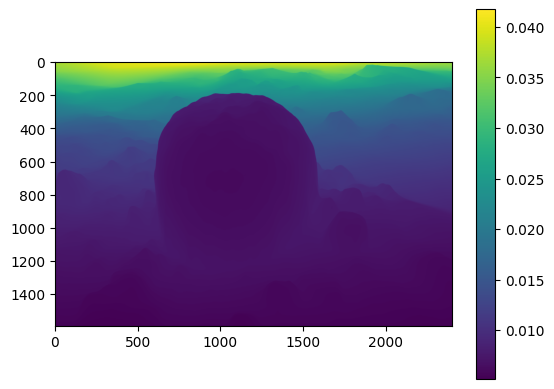

In [174]:
B_b = estimate_backscatter(b_args[0], b_args[1], b_args[2], b_args[3], tif_flat).reshape((height, width))

imshow(B_b)

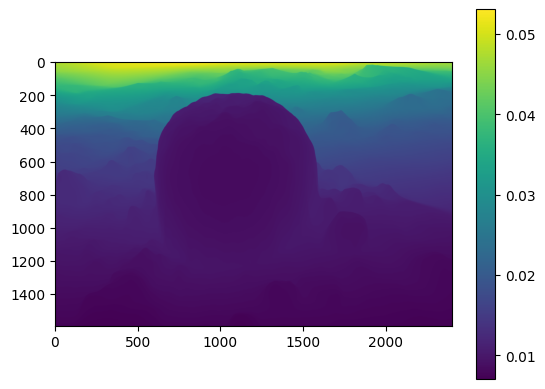

In [175]:
B_g = estimate_backscatter(g_args[0], g_args[1], g_args[2], g_args[3], tif_flat).reshape((height, width))

imshow(B_g)

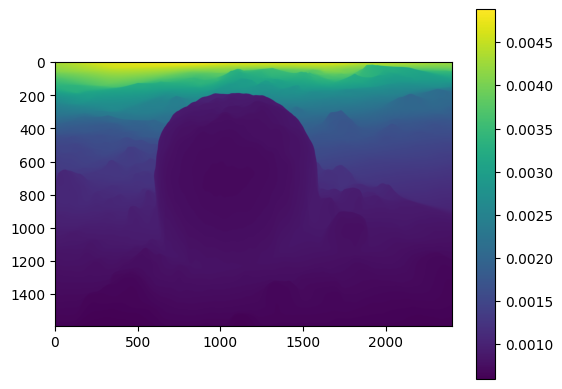

In [176]:
B_r = estimate_backscatter(r_args[0], r_args[1], r_args[2], r_args[3], tif_flat).reshape((height, width))

imshow(B_r)

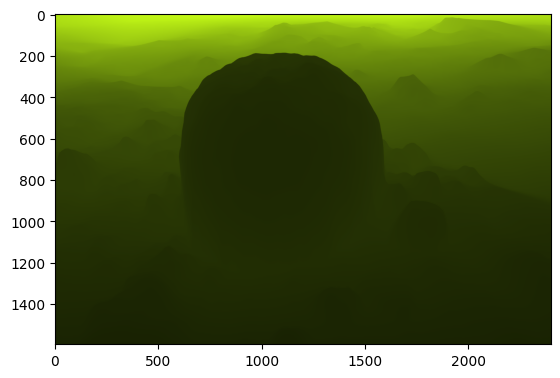

In [177]:
backscatter = np.zeros((height, width, 3), dtype=np.float64)

backscatter[:, :, 0] = B_b
backscatter[:, :, 1] = B_g
backscatter[:, :, 2] = B_r

imshow(backscatter / backscatter.max())

In [181]:
png

array([[[0.03529412, 0.03921569, 0.00392157],
        [0.03529412, 0.03921569, 0.00392157],
        [0.03529412, 0.03921569, 0.00392157],
        ...,
        [0.03529412, 0.03921569, 0.00392157],
        [0.03529412, 0.03921569, 0.00392157],
        [0.03529412, 0.03921569, 0.00392157]],

       [[0.03529412, 0.04313725, 0.00392157],
        [0.03529412, 0.03921569, 0.00392157],
        [0.03529412, 0.03921569, 0.00392157],
        ...,
        [0.03529412, 0.03921569, 0.00392157],
        [0.03529412, 0.03921569, 0.00392157],
        [0.03529412, 0.03921569, 0.00392157]],

       [[0.03921569, 0.04313725, 0.00392157],
        [0.03529412, 0.04313725, 0.00392157],
        [0.03529412, 0.04313725, 0.00392157],
        ...,
        [0.03529412, 0.03921569, 0.00392157],
        [0.03529412, 0.03921569, 0.00392157],
        [0.03529412, 0.03921569, 0.00392157]],

       ...,

       [[0.09803922, 0.16078431, 0.03529412],
        [0.10196078, 0.16470588, 0.03529412],
        [0.10196078, 0

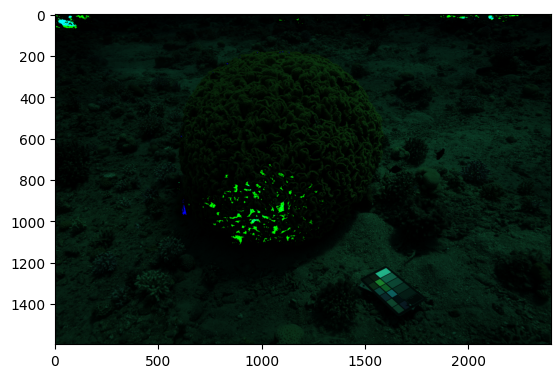

In [178]:
direct_signal = png - backscatter

# sig_min_b = direct_signal[:, :, 0].min()
# sig_min_g = direct_signal[:, :, 1].min()
# sig_min_r = direct_signal[:, :, 2].min()

# if sig_min_b > 0:
#     sig_min_b = 0

# if sig_min_g > 0:
#     sig_min_g = 0

# if sig_min_r > 0:
#     sig_min_r = 0

# direct_signal[:, :, 0] = direct_signal[:, :, 0] - sig_min_b
# direct_signal[:, :, 1] = direct_signal[:, :, 1] - sig_min_g
# direct_signal[:, :, 2] = direct_signal[:, :, 2] - sig_min_r

imshow(direct_signal, color_channel="bgr")

In [180]:
direct_signal

array([[[-0.00167215, -0.00824091, -0.0003931 ],
        [-0.00167215, -0.00824091, -0.0003931 ],
        [-0.00168202, -0.0082527 , -0.00039427],
        ...,
        [-0.00110146, -0.00755872, -0.00032538],
        [-0.00108921, -0.00754406, -0.00032393],
        [-0.00108279, -0.00753638, -0.00032316]],

       [[-0.00167215, -0.00431934, -0.0003931 ],
        [-0.00167215, -0.00824091, -0.0003931 ],
        [-0.00168202, -0.0082527 , -0.00039427],
        ...,
        [-0.00110146, -0.00755872, -0.00032538],
        [-0.00108921, -0.00754406, -0.00032393],
        [-0.00108279, -0.00753638, -0.00032316]],

       [[ 0.00228868, -0.00427245, -0.00038844],
        [-0.00163289, -0.00427245, -0.00038844],
        [-0.00164125, -0.00428244, -0.00038943],
        ...,
        [-0.00099897, -0.00743604, -0.00031322],
        [-0.00099001, -0.00742532, -0.00031216],
        [-0.00098178, -0.00741546, -0.00031118]],

       ...,

       [[ 0.09252021,  0.1532651 ,  0.03465901],
        [ 0

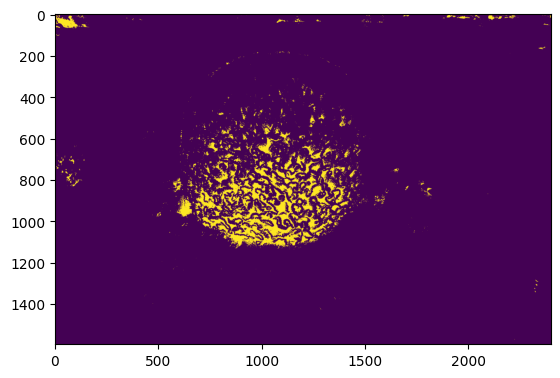

In [179]:
plt.imshow((png < backscatter)[:, :, 0])

In [108]:
np.savez_compressed(f"./output/DS_{name}.npz", direct_signal=direct_signal.astype(np.float32))

direct_signal.shape

(1596, 2400, 3)

## Attenuation Coefficient Estimation

### Coarse Estimate of $\beta_c^D(z)$

In [109]:
epsilon_percent = 0.1
convergence_threshold = 0.001
f = 2.0
p = 0.1

In [110]:
epsilon = (tif.max() - tif_flat[tif_flat != 0].min()) * epsilon_percent

epsilon

np.float32(0.73263663)

In [111]:
def pad_tensor(tensor: torch.Tensor, top: int, right: int, left: int, bottom: int) -> torch.Tensor:
    dim = len(tensor.shape)

    if len(tensor.shape) == 2:
        tensor = tensor[:, :, None]

    height, width, channels = tensor.shape

    new_height = height + top + bottom
    new_width = width + right + left

    bottom_idx = new_height - bottom
    right_idx = new_width - right

    padded = torch.zeros((new_height, new_width, channels), device=device)
    padded[top:bottom_idx, left:right_idx, :] = tensor

    if dim == 2:
        return padded[:, :]
    else:
        return padded


In [112]:
def pad_direction(tensor: torch.Tensor):
    if len(tensor.shape) == 2:
        tensor = tensor[:, :, None]

    height, width, channels = tensor.shape

    direction = torch.zeros((height + 2, width + 2, 4, channels), device=device)
    direction[:, :, 0, :] = pad_tensor(tensor, 2, 1, 1, 0)
    direction[:, :, 1, :] = pad_tensor(tensor, 1, 2, 0, 1)
    direction[:, :, 2, :] = pad_tensor(tensor, 0, 1, 1, 2)
    direction[:, :, 3, :] = pad_tensor(tensor, 1, 0, 2, 1)

    return direction

In [113]:
direct_signal_tensor = pad_tensor(torch.as_tensor(direct_signal, device=device), 1, 1, 1, 1)
a_values_tensor = direct_signal_tensor
depths_tensor = torch.as_tensor(tif, device=device)
diff_depth_map_tensor = torch.abs(torch.dstack([pad_tensor(depths_tensor, 1, 1, 1, 1)] * 4) - pad_direction(depths_tensor).squeeze())
softmax = func.softmax(-diff_depth_map_tensor, dim=-1)
weights = torch.stack([softmax] * 3, dim=-1)

for i in range(100):
    a_values_tensor = pad_direction(a_values_tensor[1:-1, 1:-1, :])
    a_values_tensor = torch.sum(weights * a_values_tensor, axis=2)
    a_values_tensor = (1 - p) * a_values_tensor + p * direct_signal_tensor

a_values_tensor.shape

torch.Size([1598, 2402, 3])

In [114]:
a_values = a_values_tensor[1:-1, 1:-1, :].detach().cpu().numpy()

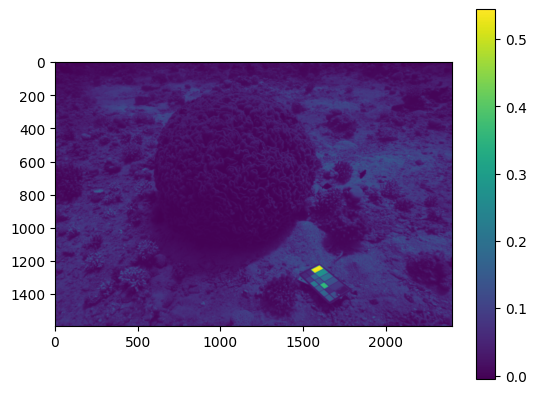

In [115]:
imshow(a_values[:, :, 0])

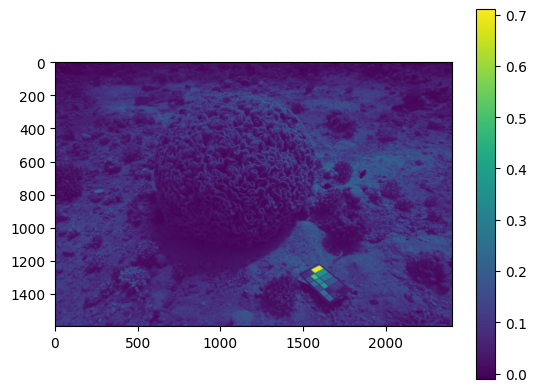

In [116]:
imshow(a_values[:, :, 1])

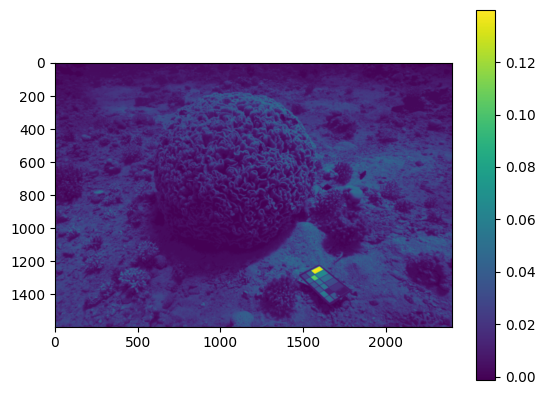

In [117]:
imshow(a_values[:, :, 2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.015106453..1.0].


1.4198896


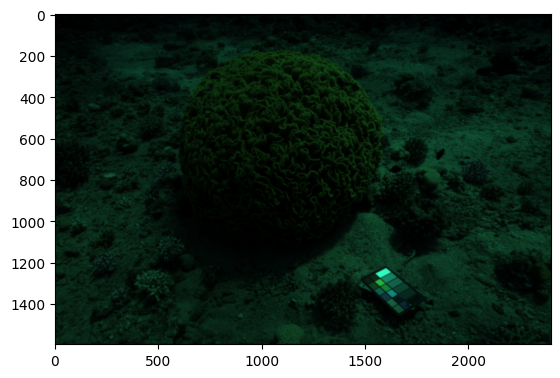

In [118]:
local_illuminant_map = f * a_values

print(local_illuminant_map.max())
imshow(local_illuminant_map / local_illuminant_map.max(), color_channel="bgr")

In [138]:
np.sort(local_illuminant_map.flatten()), (local_illuminant_map[:, :, 0] <= 0).mean()

(array([-0.02143949, -0.02141696, -0.02141041, ...,  1.4195372 ,
         1.4196796 ,  1.4198996 ], shape=(11491200,), dtype=float32),
 np.float64(0.033625208855472016))

/tmp/ipykernel_11477/3869264753.py:4: RuntimeWarning: invalid value encountered in log
  beta_d_coarse[:, :, 0] = - np.log(local_illuminant_map[:, :, 0]) / tif
/tmp/ipykernel_11477/3869264753.py:5: RuntimeWarning: invalid value encountered in log
  beta_d_coarse[:, :, 1] = - np.log(local_illuminant_map[:, :, 1]) / tif
/tmp/ipykernel_11477/3869264753.py:6: RuntimeWarning: invalid value encountered in log
  beta_d_coarse[:, :, 2] = - np.log(local_illuminant_map[:, :, 2]) / tif


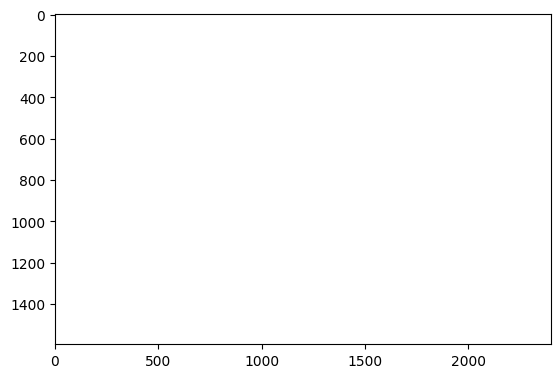

In [ ]:
beta_d_coarse = np.zeros_like(local_illuminant_map)

beta_d_coarse[:, :, 0] = - np.log(local_illuminant_map[:, :, 0]) / tif
beta_d_coarse[:, :, 1] = - np.log(local_illuminant_map[:, :, 1]) / tif
beta_d_coarse[:, :, 2] = - np.log(local_illuminant_map[:, :, 2]) / tif

beta_min = beta_d_coarse.min()
beta_max = beta_d_coarse.max() - beta_min
imshow((beta_d_coarse - beta_min) / beta_max, color_channel="bgr")

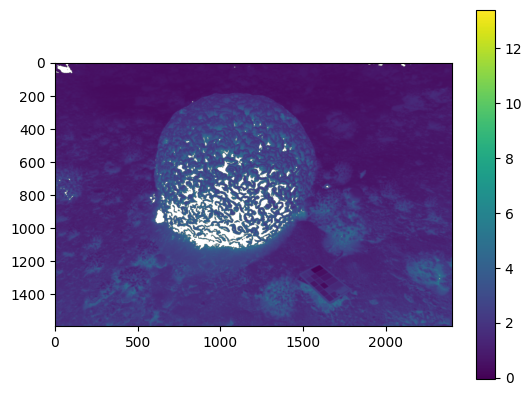

In [121]:
imshow(beta_d_coarse[:, :, 0])

In [122]:
np.sort(beta_d_coarse[:, :, 0].flatten()), np.isnan(beta_d_coarse[:,:,0].flatten()).mean(), (beta_d_coarse[:,:,0].flatten() < 0).mean()

(array([-0.06549881, -0.06515562, -0.06498153, ...,         nan,
                nan,         nan], shape=(3830400,), dtype=float32),
 np.float64(0.033625208855472016),
 np.float64(0.00032346491228070175))

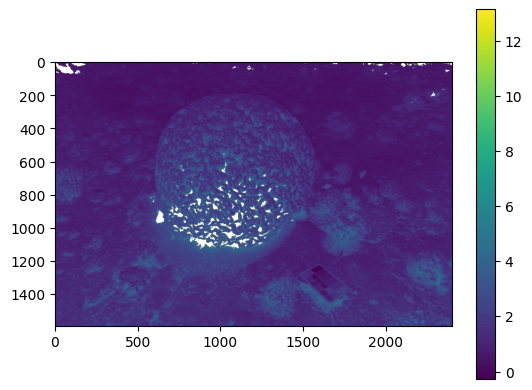

In [123]:
imshow(beta_d_coarse[:, :, 1])

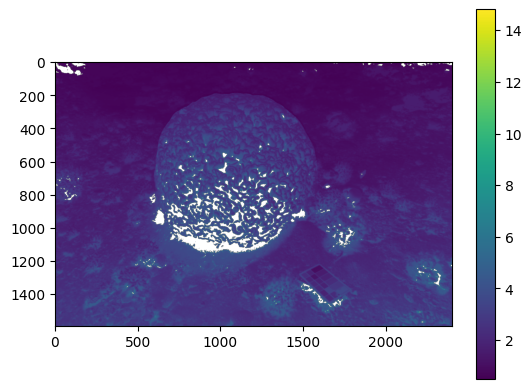

In [124]:
imshow(beta_d_coarse[:, :, 2])

### Refined Estimate of $\beta_c^D(z)$

In [125]:
def compute_beta_D(a: float, b: float, c: float, d: float, z: np.ndarray) -> np.ndarray:
    return a * np.exp(b * z) + c * np.exp(d * z)

In [126]:
def optimize_compute_beta_D(args: Tuple[float, float, float, float], E: np.ndarray, z: np.ndarray) -> np.ndarray[float]:
    a, b, c, d = args
    beta_D = compute_beta_D(a, b, c, d, z)
    z_hat = -np.log(E) / beta_D

    return (z - z_hat).flatten()

In [127]:
def leastsquares_compute_beta_D(local_illuminant_map: np.ndarray, depths: np.ndarray, color_channel: int, starts=50):
    lo = np.array([0, -np.inf, 0, -np.inf])
    hi = np.array([np.inf, 0, np.inf, 0])

    best_params = None
    best_loss = None

    for _ in range(starts):
        starting_point = np.random.random_sample(4) * 2000
        starting_point[1] /= -10
        starting_point[3] /= -10

        print(starting_point)

        try:
            result = least_squares(optimize_compute_beta_D, starting_point, args=(local_illuminant_map[:, :, color_channel], depths), bounds=(lo, hi))
        except ValueError:
            continue
        
        params = result.x
        result = optimize_compute_beta_D(params, local_illuminant_map[:, :, color_channel], depths)
        max_diff = np.abs(result).max()
        loss = (np.abs(result)).mean()

        print(loss, max_diff, params)

        if best_loss is None or loss < best_loss:
            best_params = params
            best_loss = loss
            
    return best_params, best_loss

In [128]:
local_illuminant_params_b, loss = leastsquares_compute_beta_D(local_illuminant_map, tif, 0)

local_illuminant_params_b, loss #0.282

[1536.77884125  -69.20216456 1014.87343987  -51.17956832]
[1727.17672939 -189.24836674 1937.42149072 -176.8923221 ]
[1267.02763721 -102.23041433 1468.13597097 -140.13827951]


/tmp/ipykernel_11477/1999039822.py:4: RuntimeWarning: invalid value encountered in log
  z_hat = -np.log(E) / beta_D
/tmp/ipykernel_11477/1999039822.py:4: RuntimeWarning: divide by zero encountered in divide
  z_hat = -np.log(E) / beta_D
/tmp/ipykernel_11477/1999039822.py:4: RuntimeWarning: overflow encountered in divide
  z_hat = -np.log(E) / beta_D


[1697.14721789 -194.27386279  581.37917488  -96.67135718]
[1924.35408023 -167.42945689  935.86759608 -185.15870841]
[1332.67379174  -47.05657389 1560.16002527 -190.82240173]
[ 414.7955689   -90.5158067  1654.34987346  -11.89163521]
[1563.13403774 -154.80119825 1057.30320955  -51.35259672]
[ 256.59323984 -110.8504584  1714.16496803  -46.94987492]
[1151.92363165 -127.36081867 1127.1140265   -67.42818181]
[1895.02886561  -95.06075754  404.22071618  -88.03653433]
[ 634.70203956 -164.91775674  770.26134153 -136.582632  ]
[1483.97452647 -112.2538958   922.46050324 -175.63014132]
[ 561.38985582 -116.86043971 1765.71450188  -86.92604229]
[1002.68093341  -46.87103894  992.01536176  -87.74972834]
[ 1.85010711e+03 -8.62638708e-01  3.44047198e+02 -2.94106970e+01]
[  79.59506266 -169.01195583  811.26092281 -163.16141014]
[1447.22314707 -166.61225956 1424.85031947 -182.40076007]
[ 830.80897463 -152.59982018  586.39418533 -137.12633132]
[1265.98887592  -31.12263098  344.85293651 -195.09092684]
[ 240.

(None, None)

In [129]:
local_illuminant_params_g, loss = leastsquares_compute_beta_D(local_illuminant_map, tif, 1)

local_illuminant_params_g, loss # 0.407

[ 360.36548125 -101.88325846 1228.59314612 -180.68628715]
[1528.48953927  -35.33551009  440.56301546 -172.16273746]
[1622.19276167  -49.6240187  1549.6852403   -19.72854232]


/tmp/ipykernel_11477/1999039822.py:4: RuntimeWarning: invalid value encountered in log
  z_hat = -np.log(E) / beta_D
/tmp/ipykernel_11477/1999039822.py:4: RuntimeWarning: divide by zero encountered in divide
  z_hat = -np.log(E) / beta_D
/tmp/ipykernel_11477/1999039822.py:4: RuntimeWarning: overflow encountered in divide
  z_hat = -np.log(E) / beta_D


[ 844.24745863 -162.55258402  767.02832533  -20.7469468 ]
[1824.51003666 -195.20792297  748.36280996  -77.79040451]
[  21.94691851  -97.60774254 1495.64358649  -49.94725716]
[ 807.83958133 -108.90977914 1113.32749976 -156.00738495]
[1877.68645522  -99.11467285 1151.13468862 -105.33797874]
[1569.47527586   -9.64297423 1831.68775292 -169.75701386]
[1518.60545687  -66.70206984  992.76325397  -74.55739184]
[1346.80984151 -168.93969563 1841.10492403 -173.22634137]
[1652.79884896  -59.2870779  1003.69985517 -103.98498987]
[1159.6414457   -20.09888134 1539.65103083  -51.39564906]
[1882.98297986 -129.48724546  673.64036382  -43.65529443]
[ 400.19064858  -38.08387989 1263.4643084  -154.06133224]
[ 196.78335146 -120.62218727 1363.03404373  -55.17929259]
[1512.54931331  -53.31390601  445.36108396 -153.05459445]
[1537.38246708 -116.44928445 1213.89202382 -191.1502814 ]
[ 77.96887509  -9.61068462 254.17737617 -78.53474104]
[ 181.75756686 -104.93144798 1813.44604696  -51.16585925]
[1189.57835615  -1

(None, None)

In [130]:
local_illuminant_params_r, loss = leastsquares_compute_beta_D(local_illuminant_map, tif, 2)

local_illuminant_params_r, loss # 0.205

[1962.98786426 -105.39413641  195.55981305   -3.09459685]
[1234.79477042  -21.63739872 1602.30269037  -99.75876963]
[1580.71050607 -179.42241304  511.53751277  -89.7109995 ]


/tmp/ipykernel_11477/1999039822.py:4: RuntimeWarning: invalid value encountered in log
  z_hat = -np.log(E) / beta_D
/tmp/ipykernel_11477/1999039822.py:4: RuntimeWarning: divide by zero encountered in divide
  z_hat = -np.log(E) / beta_D
/tmp/ipykernel_11477/1999039822.py:4: RuntimeWarning: overflow encountered in divide
  z_hat = -np.log(E) / beta_D


[ 321.35068519  -44.03196051 1515.64228162 -149.72775477]
[1723.97645679  -41.3500443   974.95870024 -107.00835195]
[ 172.10932175  -74.25561597 1079.62434807   -8.56917305]
[1954.95676203 -130.90212037  481.08705287  -86.50041863]
[ 288.00171594  -85.1073142  1859.06108981  -45.73133926]
[ 416.42513066 -174.11016709  345.7901182  -131.34937726]
[1801.80426655  -76.92414738 1824.64124285 -134.72542308]
[1585.04411286  -69.83434177 1584.19901647  -73.840711  ]
[1440.5517749  -144.83229785  430.84553939 -142.46603489]
[ 522.46902285 -180.33560674 1555.38794223  -62.98080001]
[ 581.66783087 -159.17508766 1022.66966296 -120.24521855]
[  61.28887708 -117.51201869 1224.80011008  -85.04954447]
[1658.48412223  -77.53094424 1858.67544784  -50.99829342]
[1300.34751929  -24.17535308  521.18902056  -18.48081868]
[ 997.73911544  -97.11836346 1803.19038789 -132.8787779 ]
[543.63544383  -7.08072705 671.64130708 -44.74190617]
[644.36560031  -7.24265298 507.60553232 -37.85068549]
[ 4.92769993e+01 -1.10

(None, None)

In [131]:
# local_illuminant_params_b = np.array([40.36737389, -5.24498546, 40.36737389, -5.24498546])
# local_illuminant_params_g = np.array([51.71813242, -4.92373242, 51.71813242, -4.92373242])
# local_illuminant_params_r = np.array([53.08643292, -5.8253201 , 53.08643292, -5.8253201 ])

In [132]:
b_loss = np.abs(optimize_compute_beta_D(local_illuminant_params_b, local_illuminant_map[:, :, 0], tif)).mean()
g_loss = np.abs(optimize_compute_beta_D(local_illuminant_params_b, local_illuminant_map[:, :, 1], tif)).mean()
r_loss = np.abs(optimize_compute_beta_D(local_illuminant_params_b, local_illuminant_map[:, :, 2], tif)).mean()

b_loss, g_loss, r_loss

TypeError: cannot unpack non-iterable NoneType object

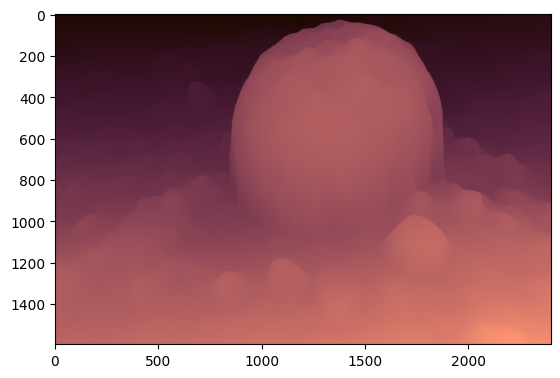

In [ ]:
beta_d = np.zeros_like(local_illuminant_map)

beta_d[:, :, 0] = compute_beta_D(local_illuminant_params_b[0], local_illuminant_params_b[1], local_illuminant_params_b[2], local_illuminant_params_b[3], tif)
beta_d[:, :, 1] = compute_beta_D(local_illuminant_params_g[0], local_illuminant_params_g[1], local_illuminant_params_g[2], local_illuminant_params_g[3], tif)
beta_d[:, :, 2] = compute_beta_D(local_illuminant_params_r[0], local_illuminant_params_r[1], local_illuminant_params_r[2], local_illuminant_params_r[3], tif)

beta_d_min = beta_d.min()
beta_d_max = beta_d.max() - beta_d_min
imshow((beta_d - beta_d_min) / beta_d_max, color_channel="bgr")

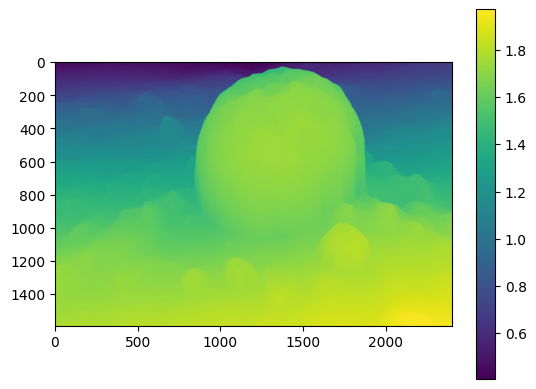

In [ ]:
imshow(beta_d[:, :, 0])

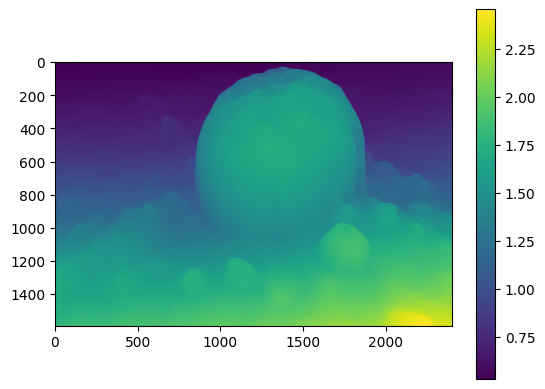

In [ ]:
imshow(beta_d[:, :, 1])

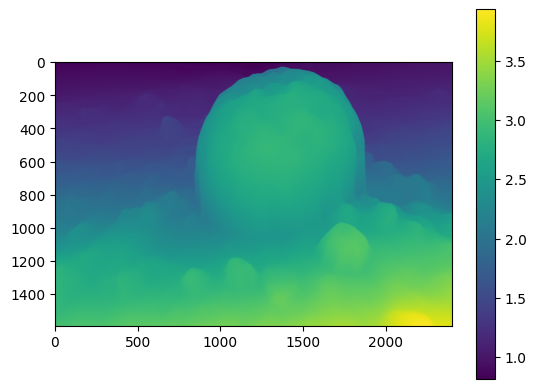

In [ ]:
imshow(beta_d[:, :, 2])

In [ ]:
(direct_signal[:, :, 0] * np.exp(beta_d[:, :, 0] * tif)).max()

np.float64(4.971159121112387)

In [ ]:
(direct_signal[:, :, 1] * np.exp(beta_d[:, :, 1] * tif)).max()

np.float64(5.992120528778684)

In [ ]:
(direct_signal[:, :, 2] * np.exp(beta_d[:, :, 2] * tif)).max()

np.float64(4.879165395434378)

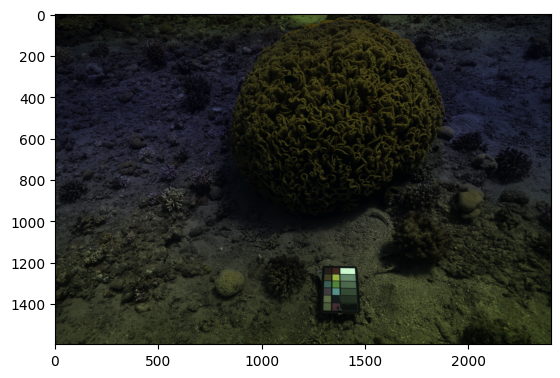

In [ ]:
J = np.zeros_like(direct_signal)

J[:, :, 0] = direct_signal[:, :, 0] * np.exp(beta_d[:, :, 0] * tif)
J[:, :, 1] = direct_signal[:, :, 1] * np.exp(beta_d[:, :, 1] * tif)
J[:, :, 2] = direct_signal[:, :, 2] * np.exp(beta_d[:, :, 2] * tif)

# J[:, :, 0] = J[:, :, 0] / J[:, :, 0].max()
# J[:, :, 1] = J[:, :, 1] / J[:, :, 1].max()
# J[:, :, 2] = J[:, :, 2] / J[:, :, 2].max()

J = J / J.max()

imshow(J, color_channel="bgr")

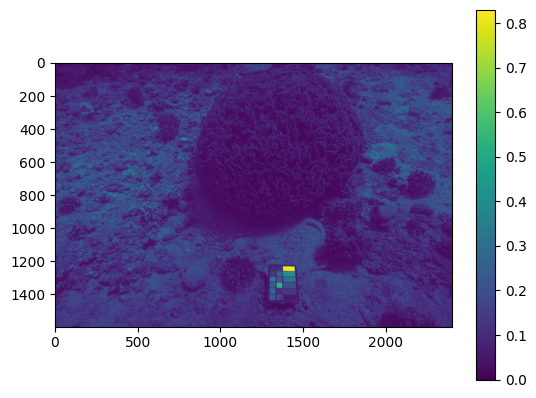

In [ ]:
imshow(J[:, :, 0])

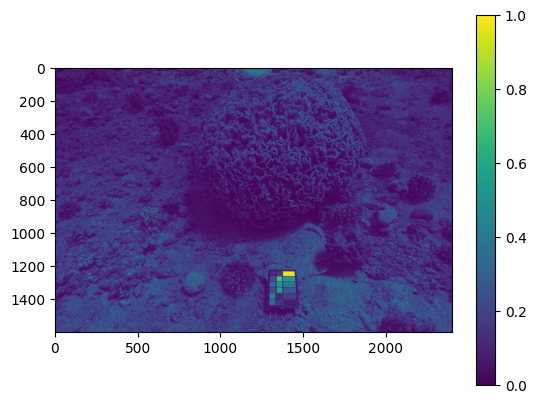

In [ ]:
imshow(J[:, :, 1])

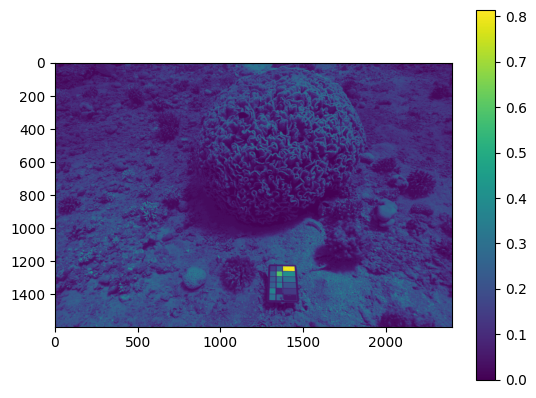

In [ ]:
imshow(J[:, :, 2])

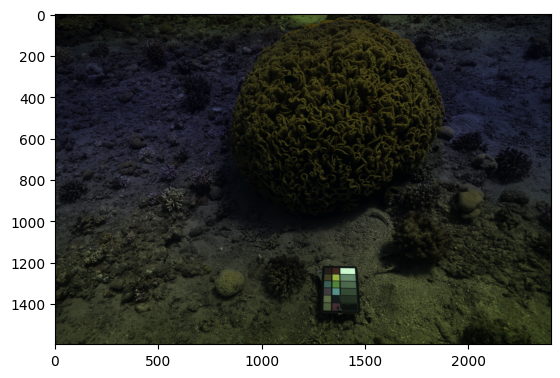

In [ ]:
J_8 = double_2_uint8(J)

imshow(J, color_channel="bgr")

In [65]:
def gray_world(image):
    """
    White balance image using Gray-world algorithm.
    """
    access_gw = ((image * (image.mean() / image.mean(axis=(0, 1))))
             .clip(0, 255))
    
    return access_gw

In [66]:
def scale(img):
    return img_as_ubyte((img - np.min(img)) / (np.max(img) - np.min(img)))

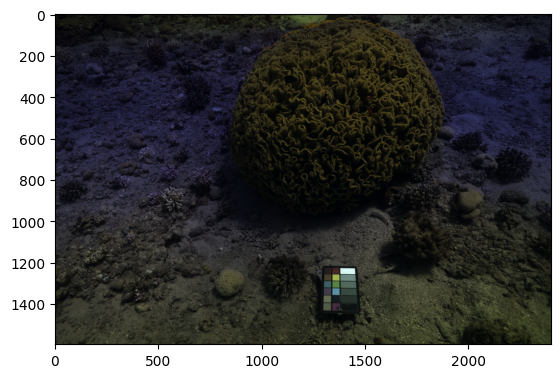

In [ ]:
J_gray_world = scale(gray_world(J_8.astype(np.float64)))

imshow(J_gray_world, color_channel="bgr")

In [68]:
def white_patch(image, percentile=50):
    """
    Adjust the color balance of an image based on the white patch method.
    """
    access_wp2 = ((image*1.0 / np.percentile(image, percentile, 
                                                         axis=(0, 1)))
                              .clip(0, 1))
    return access_wp2

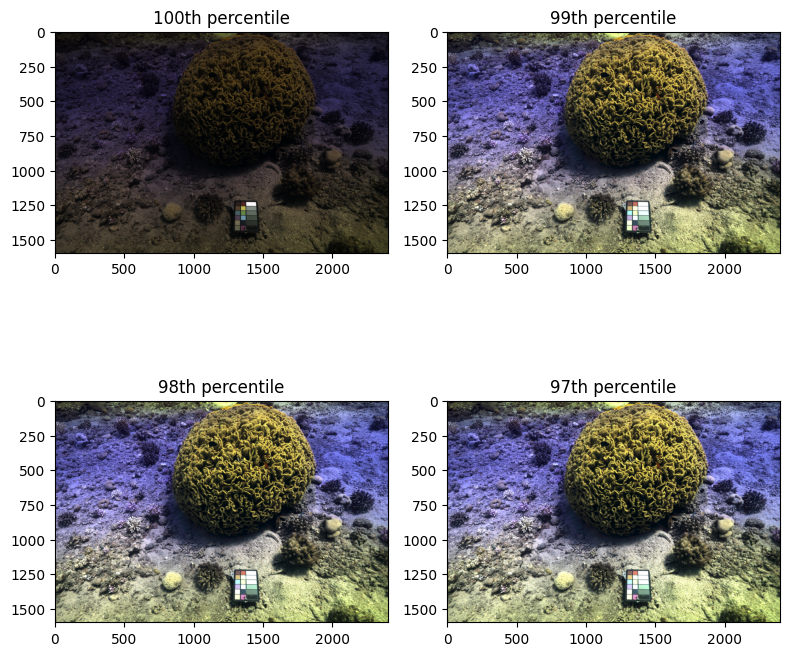

In [ ]:
pcts = [100, 99, 98, 97]
op_wp = J_8*1.0 / J_8.max(axis=(0,1))
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

for idx, pct in enumerate(pcts):
    op_wp2 = img_as_ubyte(white_patch(op_wp, pct))
    axs[idx].imshow(cv2.cvtColor(op_wp2, cv2.COLOR_BGR2RGB))
    axs[idx].set_title(f'{pct}th percentile')

plt.tight_layout()
plt.show()

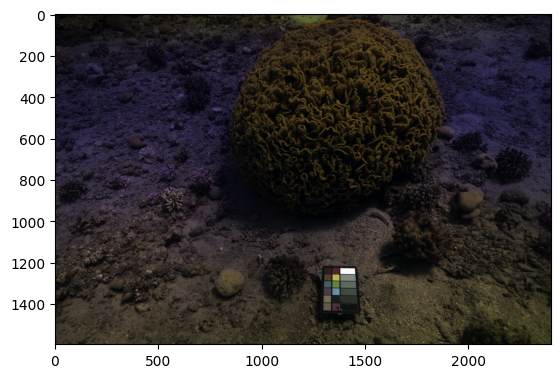

In [ ]:
op_wp = img_as_ubyte(J_8*1.0 / J_8.max(axis=(0,1)))
img = img_as_ubyte(white_patch(op_wp, 100))

imshow(img, color_channel="bgr")

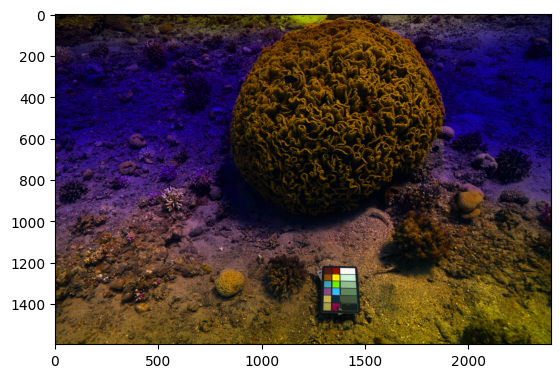

In [ ]:
hsv = uint8_2_double(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
hsv[:, :, 1] *= 2.2
hsv[:, :, 2] *= 1.8

hsv[hsv[:, :, 1] >= 1, 1] = 1
hsv[hsv[:, :, 2] >= 1, 2] = 1

imshow(hsv, color_channel="hsv")

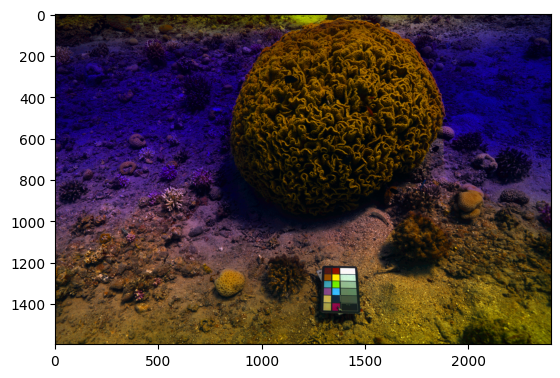

In [ ]:
img_adjusted = cv2.cvtColor(img_as_ubyte(hsv), cv2.COLOR_HSV2BGR)

imshow(img_adjusted, color_channel="bgr")

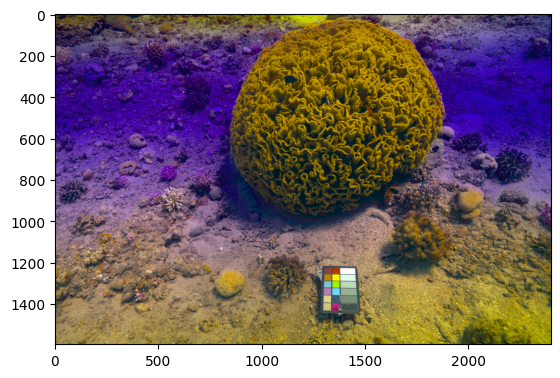

In [ ]:
img_gamma = skimage.exposure.adjust_gamma(img_adjusted, gamma=0.55)

imshow(img_gamma, color_channel="bgr")

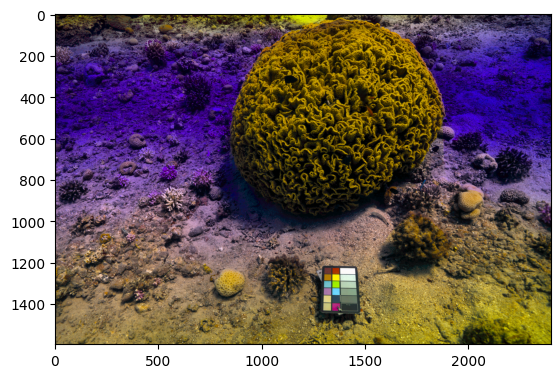

In [ ]:
img_hist = skimage.exposure.equalize_adapthist(img_gamma)

imshow(img_hist, color_channel="bgr")

In [ ]:
cv2.imwrite("output/crutchfield_perry_final.png", img_as_ubyte(img_hist))

True